# Imports

In [36]:
import torch
import torchvision 
import torch.nn.functional as F 
import torchvision.datasets as datasets  
import torchvision.transforms as transforms
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader 
from tqdm import tqdm  
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf

## Download dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


## Preparing dataloader

In [3]:
def get_data_loader(dataset):
  
  left_imgs, right_imgs = split_images(dataset)
  data = []
  for idx, img in enumerate(x_train):
    left = img[:,:14]
    right = img[:,14:]
    data.append((left,right))
  data = np.array(data)

  X = torch.tensor(data)
  loader = DataLoader(dataset=X, batch_size=64, shuffle=True)

  return loader

## Splitting dataset into left and right images

In [4]:
def split_images(data):
  left_imgs = np.zeros((60000,28,14))
  right_imgs = np.zeros((60000,28,14))
  for idx, img in enumerate(data):
      left_imgs[idx] = img[:,:14]
      right_imgs[idx] = img[:,14:]
  return left_imgs, right_imgs

In [5]:
train_loader = get_data_loader(x_train)

In [6]:
test_loader = get_data_loader(x_test)

# Autoencoder
* Feeding batches of 64 images to left half feed and right half feed before the merged middle layer in the network.

* Then the hidden layer separates into two again, reconstructing the left and right views. 

* 64 x 10 dimension output for both left and right image batches as we have 64 images and embeddings are of size 10 as of now.

In [7]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()        
        ### ENCODING
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32, 1e-05, 0.1)
        self.bn2 = nn.BatchNorm2d(64, 1e-05, 0.1)

        self.convleft1 = nn.Conv2d(1, 32, kernel_size=3)
        self.convleft2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fcleft1 = nn.Linear(64*5*2, 512)
        self.fcleft2 = nn.Linear(512, 128)
        self.fcleft3 = nn.Linear(128, 10)
        
        self.convright1 = nn.Conv2d(1, 32, kernel_size=3)
        self.convright2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fcright1 = nn.Linear(64*5*2, 512)
        self.fcright2 = nn.Linear(512, 128)
        self.fcright3 = nn.Linear(128, 10)

        ### DECODING
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.linearleft1 = nn.Linear(20, 128)
        self.linearleft2 = nn.Linear(128, 64*5*2)
        self.deconvleft1 = nn.ConvTranspose2d(64, 32, kernel_size=(2, 2))
        self.deconvleft2 = nn.ConvTranspose2d(32, 1, kernel_size=(3, 2)) 


        self.linearright1 = nn.Linear(20, 128)
        self.linearright2 = nn.Linear(128, 64*5*2)
        self.deconvright1 = nn.ConvTranspose2d(64, 32, kernel_size=(2, 2))
        self.deconvright2 = nn.ConvTranspose2d(32, 1, kernel_size=(3, 2))
        
    def forward(self, x):
        #ENCODING
        left = x[:,:,0,:,:]
        right = x[:,:,1,:,:]
        
        #  LEFT FIRST HALF
        x = F.relu(self.convleft1(left))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.convleft2(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = x.reshape(64,-1) 
        hleft1 = F.relu(self.fcleft1(x))
        hleft2 = F.relu(self.fcleft2(hleft1))
        hleft3 = F.relu(self.fcleft3(hleft2))

        # RIGHT FIRST HALF
        y = F.relu(self.convright1(right))
        y = self.pool(y)
        y = self.bn1(y)
        y = F.relu(self.convright2(y))
        y = self.pool(y)
        y = self.bn2(y)
        y = y.reshape(64,-1) 
        hright1 = F.relu(self.fcright1(y))
        hright2 = F.relu(self.fcright2(hright1))
        hright3 = F.relu(self.fcright3(hright2))
        
        #MERGE
        hcommon = torch.cat((hleft3, hright3), 1)

        #DECODING
        a = F.relu(self.linearleft1(hcommon))
        a = F.relu(self.linearleft2(a))
        a = a.reshape(64, 64, 5, 2)
        a = F.relu(self.deconvleft1(a))
        a = self.upsample(a)
        recleft = F.relu(self.upsample(self.deconvleft2(a)))

        a = F.relu(self.linearright1(hcommon))
        a = F.relu(self.linearright2(a))
        a = a.reshape(64, 64, 5, 2)
        a = F.relu(self.deconvright1(a))
        a = self.upsample(a)
        recright = F.relu(self.upsample(self.deconvright2(a)))
        
        return(hcommon, recleft, recright, hleft1, hleft2, hright1, hright2)

In [8]:
def correlation(h_layers):
    lambda_arr = [0.02, 0.001, 0.05]
    corr_arr = np.zeros(len(lambda_arr))
    for index,pair in enumerate(h_layers):
        lmbda = lambda_arr[index]
        x=pair[0]
        y=pair[1]
        
        x_mean = torch.mean(x, axis=0)
        y_mean = torch.mean(y, axis=0)
        x_numerator1 = x-x_mean
        y_numerator1 = y-y_mean
        
        corr_numerator = torch.sum(x_numerator1*y_numerator1, axis=0)
        corr_denominator1 = torch.sqrt(torch.sum(x_numerator1*x_numerator1, axis=0) + 1e-8)
        corr_denominator2 = torch.sqrt(torch.sum(y_numerator1*y_numerator1, axis=0) + 1e-8)
        corr = corr_numerator / (corr_denominator1 * corr_denominator2)
        
        corr_arr[index] = lmbda*torch.sum(corr)
    return np.sum(corr_arr)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [11]:
def plot_loss(train_loss, num_epoch):
    plt.plot(train_loss, '-ro')
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("Train Loss vs Epoch")

# Training the Model

In [12]:
model = NN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
reset_network_params(model)
num_epochs = 20
train_loss = []
for i in tqdm(range(num_epochs)):
    j = 0
    epoch_loss = 0.0
    for x in train_loader:
        if (x.shape[0]!=64):
            continue
        x = x.to(device=device)
        x = x.reshape(64,1,2,28,14)
        x = x.float()

        left = x[:, :, 0, :, :].to(device=device)
        right = x[:, :,1, :, :].to(device=device)
        left = left.reshape(64,1,1,28,14)
        right = right.reshape(64,1,1,28,14)

        templ, tempr = x.detach().clone(), x.detach().clone()
        templ[:, :, 0, :, :]=0
        tempr[:, :, 1, :, :]=0

        h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
        left0 = left0.reshape(64,1,1,28,14)
        right0 = right0.reshape(64,1,1,28,14)
        h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
        h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
        left1 = left1.reshape(64,1,1,28,14)
        right2 = right2.reshape(64,1,1,28,14)
        left2 = left2.reshape(64,1,1,28,14)
        right1 = right1.reshape(64,1,1,28,14)

        #MSE Loss + Correlation
        loss=criterion(left0, left)+criterion(right0, right)+criterion(left2, left)+criterion(right1, right)-correlation([[h1, h2], [hleft_1, hright_1], [hleft_2, hright_2]])
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(epoch_loss)

100%|██████████| 20/20 [05:09<00:00, 15.49s/it]


# Plotting Training Loss vs Epochs

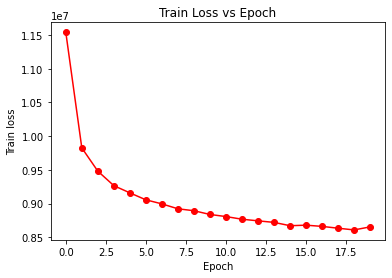

In [14]:
plot_loss(train_loss, num_epochs)

# Displaying Outputs

### Display 64 random images, used only 6400 test images to prevent colab from crashing due to memory usage

In [54]:
def show_sample_reconstructions(reconstructions, actual, flag = 0):
    idx = 1
    indices = random.sample(range(0, 6400), 64)
    fig=plt.figure(figsize=(12, 12))
    columns, rows = 8, 8
    for i in range(0, columns*rows):
        if flag:
            fig.add_subplot(rows, columns, idx)
            imX = cv2.hconcat([reconstructions[indices[idx-1],:,:], actual[indices[idx-1],:,:]])
        else:
            fig.add_subplot(rows, columns, idx)
            imX = cv2.hconcat([actual[indices[idx-1],:,:], reconstructions[indices[idx-1],:,:]])
        plt.axis('off')
        plt.imshow(imX)
        idx += 1
    plt.show()

### Testing for 1st 6400 test images

In [21]:
def test_image_reconstruct(model, test_loader):
    device2 = torch.device('cpu')
    model = model.to(device=device2)
    LEFT1 = torch.zeros((1,28,14))
    LEFT2 = torch.zeros(1,28,14)
    RIGHT1 = torch.zeros(1,28,14)
    RIGHT2 = torch.zeros(1,28,14)
    actual = torch.zeros(1,1,2,28,14)
    i = 0
    for x in train_loader:
        if (i==100):
            break
        x = x.to(device=device2)
        x = x.reshape(64,1,2,28,14)
        x = x.float()
        templ, tempr = x.detach().clone(), x.detach().clone()
        templ[:, :, 0, :, :]=0
        tempr[:, :, 1, :, :]=0
        # h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
        h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
        h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
        left1 = left1.reshape(64,1,1,28,14).squeeze().cpu()
        right2 = right2.reshape(64,1,1,28,14).squeeze().cpu()
        left2 = left2.reshape(64,1,1,28,14).squeeze().cpu()
        right1 = right1.reshape(64,1,1,28,14).squeeze().cpu()
        
        LEFT1 = torch.vstack((LEFT1, left1))
        RIGHT1 = torch.vstack((RIGHT1, right1))
        LEFT2 = torch.vstack((LEFT2, left2))
        RIGHT2 = torch.vstack((RIGHT2, right2)) 
        actual = torch.vstack((actual, x)) 
        i += 1
    return LEFT1[1:,:,:], RIGHT1[1:,:,:], LEFT2[1:,:,:], RIGHT2[1:,:,:], actual[1:,:,:]
     


In [22]:
LEFT1, RIGHT1, LEFT2, RIGHT2, actual = test_image_reconstruct(model, test_loader)     
actual = actual.squeeze()
print(LEFT1.size(), RIGHT1.size(), LEFT2.size(), RIGHT2.size(), actual.size())

torch.Size([6400, 28, 14]) torch.Size([6400, 28, 14]) torch.Size([6400, 28, 14]) torch.Size([6400, 28, 14]) torch.Size([6400, 2, 28, 14])


# Predicted Cross Reconstruction

## Left Input - Right Output

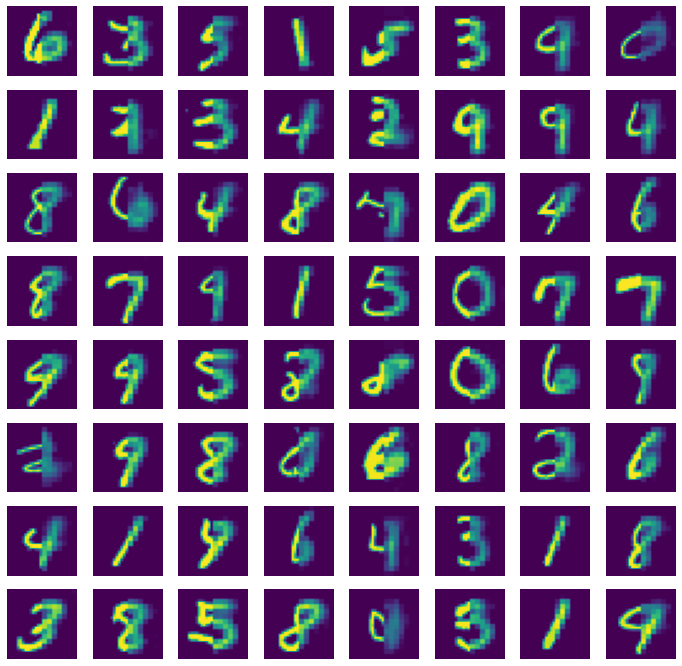

In [55]:
ACTUAL = actual.cpu().detach().numpy()
ACTUAL = ACTUAL[:,0,:,:]
ACTUAL = ACTUAL.squeeze()
show_sample_reconstructions(RIGHT1.cpu().detach().numpy(), ACTUAL)

## Right Input - Left Output

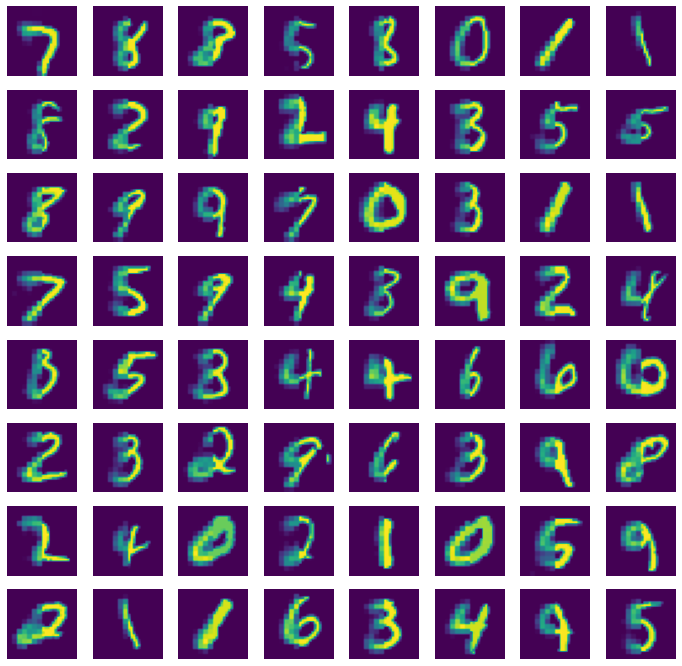

In [56]:
ACTUAL = actual.cpu().detach().numpy()
ACTUAL = ACTUAL[:,1,:,:]
ACTUAL = ACTUAL.squeeze()
show_sample_reconstructions(LEFT2.cpu().detach().numpy(), ACTUAL, 1)

# Predicted Self Reconstruction

## Left Input - Left Output

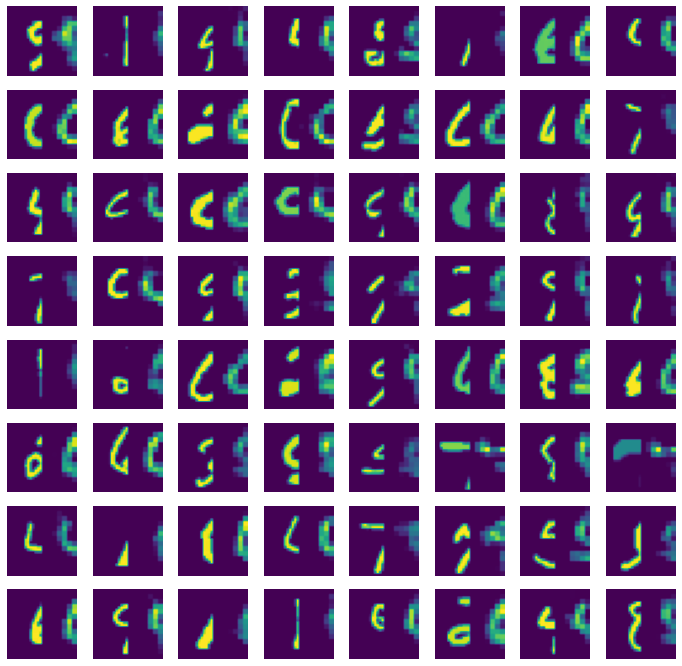

In [61]:
ACTUAL = actual.cpu().detach().numpy()
ACTUAL = ACTUAL[:,0,:,:]
ACTUAL = ACTUAL.squeeze()
show_sample_reconstructions(LEFT1.cpu().detach().numpy(), ACTUAL)

## Right Input - Right Output

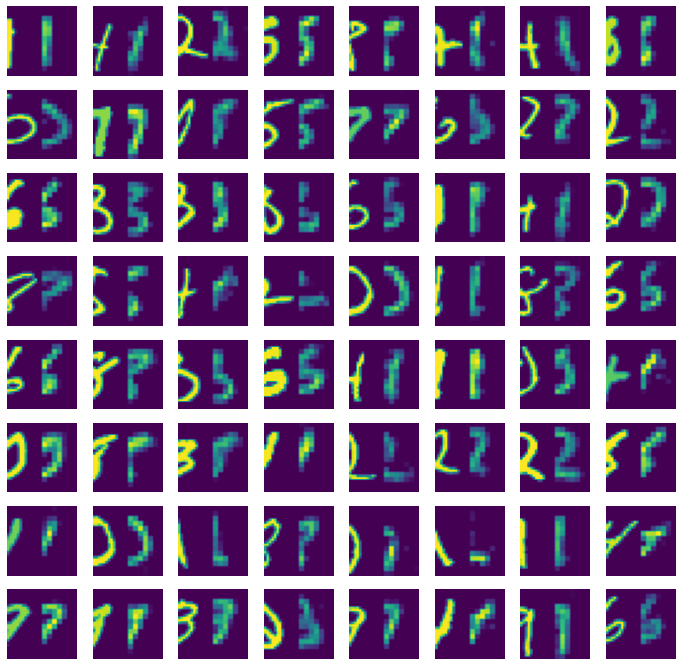

In [58]:
ACTUAL = actual.cpu().detach().numpy()
ACTUAL = ACTUAL[:,1,:,:]
ACTUAL = ACTUAL.squeeze()
show_sample_reconstructions(RIGHT2.cpu().detach().numpy(), ACTUAL)